In [142]:
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow import keras 
#from tensorflow.keras import layers
import lightgbm
import statsmodels.api as sm

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

import sqlite3

import warnings
warnings.filterwarnings('ignore')

In [143]:
from stravalib.client import Client
client = Client()

In [144]:
MY_STRAVA_CLIENT_ID, MY_STRAVA_CLIENT_SECRET = open('client.secret').read().strip().split(',')
print ('Client ID and secret read from file'.format(MY_STRAVA_CLIENT_ID) )

Client ID and secret read from file


In [145]:
MY_STRAVA_CLIENT_ID

'74972'

In [146]:
MY_STRAVA_CLIENT_SECRET

'6e77a66e9e6a4adc3329c94ede5dafa9130c8941'

In [147]:
#url = client.authorization_url(client_id=MY_STRAVA_CLIENT_ID, redirect_uri='http://127.0.0.1:5000/authorization', scope=['read_all','profile:read_all','activity:read_all'])
url = client.authorization_url(client_id=MY_STRAVA_CLIENT_ID, redirect_uri='http://127.0.0.1:5000/authorization', scope=['read_all','profile:read_all','activity:read'])

In [148]:
print(url)

https://www.strava.com/oauth/authorize?client_id=74972&redirect_uri=http%3A%2F%2F127.0.0.1%3A5000%2Fauthorization&approval_prompt=auto&response_type=code&scope=read_all%2Cprofile%3Aread_all%2Cactivity%3Aread


In [149]:
CODE = "395a65d1eb25cd19c4134b097e60f2ae1ff96675"

In [150]:
CODE

'395a65d1eb25cd19c4134b097e60f2ae1ff96675'

In [151]:
access_token = (client.exchange_code_for_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, code=CODE))
with open('../access_token.pickle', 'wb') as f:
    pickle.dump(access_token, f)

In [152]:
with open('../access_token.pickle', 'rb') as f:
    access_token = pickle.load(f)
    
print('Latest access token read from file:')
access_token

Latest access token read from file:


{'access_token': 'd50e6110285b76571c5118bdd700856e67c680e2',
 'refresh_token': 'ce683f105a8bfacf2a5baa668f29d63763a1d266',
 'expires_at': 1668045354}

In [153]:
time.time()

1668023756.212178

In [154]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))

'2022-11-09 20:55:56'

In [155]:
clock_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(access_token['expires_at']))
print(clock_time)
if time.time() > access_token['expires_at']:
    print('Token has expired, will refresh')
    refresh_response = client.refresh_access_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, refresh_token=access_token['refresh_token'])
    access_token = refresh_response
    with open('../access_token.pickle', 'wb') as f:
        pickle.dump(refresh_response, f)
    print('Refreshed token saved to file')
    client.access_token = refresh_response['access_token']
    client.refresh_token = refresh_response['refresh_token']
    client.token_expires_at = refresh_response['expires_at']
        
else:
    print('Token still valid, expires at {}'
          .format(time.strftime("%a, %d %b %Y %H:%M:%S %Z", time.localtime(access_token['expires_at']))))
    client.access_token = access_token['access_token']
    client.refresh_token = access_token['refresh_token']
    client.token_expires_at = access_token['expires_at']

2022-11-10 02:55:54
Token still valid, expires at Thu, 10 Nov 2022 02:55:54 W. Europe Standard Time


In [156]:
athlete = client.get_athlete()
print("Athlete's name is {} {}, based in {}, {}"
      .format(athlete.firstname, athlete.lastname, athlete.city, athlete.country))

Unable to set attribute activity_types on entity <Club id=29215 name='Eskilstuna CK' resource_state=2>
Unable to set attribute activity_types_icon on entity <Club id=29215 name='Eskilstuna CK' resource_state=2>
Unable to set attribute dimensions on entity <Club id=29215 name='Eskilstuna CK' resource_state=2>
Unable to set attribute activity_types on entity <Club id=244400 name='Eskilstuna Runners' resource_state=2>
Unable to set attribute activity_types_icon on entity <Club id=244400 name='Eskilstuna Runners' resource_state=2>
Unable to set attribute dimensions on entity <Club id=244400 name='Eskilstuna Runners' resource_state=2>
Unable to set attribute activity_types on entity <Club id=449676 name='AB Volvo Satsar Friskt' resource_state=2>
Unable to set attribute activity_types_icon on entity <Club id=449676 name='AB Volvo Satsar Friskt' resource_state=2>
Unable to set attribute dimensions on entity <Club id=449676 name='AB Volvo Satsar Friskt' resource_state=2>
Unable to set attribut

Athlete's name is Jerker Åberg, based in , 


In [19]:
activities = client.get_activities(limit=2000)
list(activities)[0:10]

[<Activity id=8061003811 name='MMA Fitness' resource_state=2>,
 <Activity id=8053377434 name='Wahoo SYSTM: Tasmania: Cygnet Coast Road' resource_state=2>,
 <Activity id=8042962209 name='Afternoon Ride ' resource_state=2>,
 <Activity id=8038451027 name='Evening Ride' resource_state=2>,
 <Activity id=8036643169 name='Afternoon Ride ' resource_state=2>,
 <Activity id=8031217762 name='Wahoo SYSTM: Nine Hammers' resource_state=2>,
 <Activity id=8015128953 name='MMA Fitness ' resource_state=2>,
 <Activity id=8007280040 name='Afternoon Ride ' resource_state=2>,
 <Activity id=7996994065 name='Wahoo SYSTM: The Downward Spiral' resource_state=2>,
 <Activity id=7990780109 name='MMA Fitness ' resource_state=2>]

In [20]:
res_list = []

for activity in activities:
    res_dict = {}
    res_dict["id"] = activity.id
    res_dict["suffer_score"] = activity.suffer_score
    res_dict["max_hr"] = activity.max_heartrate
    res_dict["mean_hr"] = activity.average_heartrate
    res_dict["mean_watts"] = activity.average_watts
    res_dict["calories"] = activity.calories
    res_dict["moving_time"] = activity.moving_time
    res_dict["elapsed_time"] = activity.elapsed_time
    res_dict["type"] = activity.type
    res_dict["start_date"] = activity.start_date
    res_dict["name"] = activity.name
    res_dict["weighted_mean_watts"] = activity.weighted_average_watts
    res_dict["elev_gain"] = activity.total_elevation_gain
    res_dict["kilojoules"] = activity.kilojoules
    

    res_list.append(res_dict)



In [21]:
df = pd.DataFrame(res_list)
df["year"] = pd.to_datetime(df["start_date"]).dt.isocalendar().year
df.head()

id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0  8061003811          72.0   168.0    143.0         NaN     None   
1  8053377434          93.0   171.0    149.9       184.6     None   
2  8042962209          16.0   163.0    118.1       138.6     None   
3  8038451027          27.0   157.0    121.3       166.7     None   
4  8036643169           7.0   129.0    109.5       164.2     None   

      moving_time    elapsed_time     type                start_date  \
0 0 days 00:54:52 0 days 00:54:52  Workout 2022-11-03 05:24:29+00:00   
1 0 days 00:49:52 0 days 00:49:52     Ride 2022-11-01 15:23:48+00:00   
2 0 days 00:45:40 0 days 00:51:19     Ride 2022-10-30 13:06:47+00:00   
3 0 days 00:52:51 0 days 01:07:48     Ride 2022-10-29 16:31:44+00:00   
4 0 days 00:36:24 0 days 00:48:43     Ride 2022-10-29 11:41:45+00:00   

                                       name  weighted_mean_watts elev_gain  \
0                               MMA Fitness                  NaN    0.00 m   
1  Wahoo SYSTM: Tasmania: Cygnet Coast Road                201.0    0.00 m   
2                           Afternoon Ride                   NaN  201.00 m   
3                              Evening Ride                  NaN  262.00 m   
4                           Afternoon Ride                   NaN  204.00 m   

   kilojoules  year  
0         NaN  2022  
1       552.4  2022  
2       379.8  2022  
3       528.7  2022  
4       358.5  2022

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   1223 non-null   int64              
 1   suffer_score         1082 non-null   float64            
 2   max_hr               1082 non-null   float64            
 3   mean_hr              1082 non-null   float64            
 4   mean_watts           774 non-null    float64            
 5   calories             0 non-null      object             
 6   moving_time          1223 non-null   timedelta64[ns]    
 7   elapsed_time         1223 non-null   timedelta64[ns]    
 8   type                 1223 non-null   object             
 9   start_date           1223 non-null   datetime64[ns, UTC]
 10  name                 1223 non-null   object             
 11  weighted_mean_watts  149 non-null    float64            
 12  elev_gain           

In [134]:
# extract date only from numpy.datetime64 variable
df["start_date"] = pd.to_datetime(df["start_date"]).dt.date

df['date'] = pd.to_datetime(df['start_date']).dt.date

df["elev_gain"] = df["elev_gain"].astype("str").str.replace(" m", "", regex=False)

df["elev_gain"] = df["elev_gain"].astype("float")

In [135]:
# save dataframe df in a sqlite database with columns as headers and rows as values 
conn = sqlite3.connect('strava.db')
df.to_sql('activities', conn, if_exists='replace', index=False)
conn.close()

# read dataframe df from sqlite database
conn = sqlite3.connect('strava.db')
df_test = pd.read_sql_query('select * from activities', conn)
conn.close()


In [136]:

# read dataframe df from sqlite database
conn = sqlite3.connect('strava.db')
df = pd.read_sql_query('select * from activities', conn)
c = conn.cursor()
c.execute("SELECT * FROM activities")
print(c.fetchone())
conn.close()

(8061003811, 72.0, 168.0, 143.0, None, None, 3292000000000, 3292000000000, 'Workout', '2022-11-03', 'MMA Fitness', None, 0.0, None, 2022, '2022-11-03')


In [129]:
df.head()

id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0  8061003811          72.0   168.0    143.0         NaN     None   
1  8053377434          93.0   171.0    149.9       184.6     None   
2  8042962209          16.0   163.0    118.1       138.6     None   
3  8038451027          27.0   157.0    121.3       166.7     None   
4  8036643169           7.0   129.0    109.5       164.2     None   

     moving_time   elapsed_time     type                 start_date  \
0  3292000000000  3292000000000  Workout  2022-11-03 05:24:29+00:00   
1  2992000000000  2992000000000     Ride  2022-11-01 15:23:48+00:00   
2  2740000000000  3079000000000     Ride  2022-10-30 13:06:47+00:00   
3  3171000000000  4068000000000     Ride  2022-10-29 16:31:44+00:00   
4  2184000000000  2923000000000     Ride  2022-10-29 11:41:45+00:00   

                                       name  weighted_mean_watts elev_gain  \
0                               MMA Fitness                  NaN      0.00   
1  Wahoo SYSTM: Tasmania: Cygnet Coast Road                201.0      0.00   
2                           Afternoon Ride                   NaN    201.00   
3                              Evening Ride                  NaN    262.00   
4                           Afternoon Ride                   NaN    204.00   

   kilojoules  year  
0         NaN  2022  
1       552.4  2022  
2       379.8  2022  
3       528.7  2022  
4       358.5  2022

In [130]:
cond = df.name.str.lower().str.contains("hammers")# == 7601785885#7601785885
# use loc to filter the dataframe based on the condition above and select the column start_date 
df.loc[cond].sort_values("id")#, "start_date"]
#df[cond].loc["start_date"]#.values#.strftime("%Y-%m-%d")

id  suffer_score  max_hr  mean_hr  mean_watts calories  \
564  2677299933          92.0   176.0    144.1       210.6     None   
469  2987119442          72.0   167.0    140.0       203.4     None   
461  3004307546          83.0   168.0    143.6       211.2     None   
450  3025153587          85.0   167.0    144.8       216.5     None   
438  3045837646          79.0   173.0    142.9       221.1     None   
429  3065631046          80.0   168.0    143.1       224.0     None   
424  3086063316          86.0   170.0    144.4       224.2     None   
406  3126326839          93.0   172.0    145.8       222.7     None   
390  3175459045           NaN     NaN      NaN       215.7     None   
380  3241849794         108.0   176.0    149.0       216.2     None   
362  3357980775         100.0   174.0    147.6       213.7     None   
360  3379261884          98.0   174.0    147.1       221.4     None   
354  3418305919          92.0   174.0    145.8       217.2     None   
349  3466480442          97.0   178.0    147.5       214.3     None   
294  4057964600         135.0   175.0    154.4       180.2     None   
247  4417559771           NaN     NaN      NaN       207.5     None   
241  4451583960           NaN     NaN      NaN       210.5     None   
178  5269621743          79.0   174.0    142.8       207.8     None   
120  6103753599          63.0   170.0    123.3       198.1     None   
92   6722790718         120.0   177.0    152.1       182.3     None   
74   7029385134          98.0   174.0    147.5       192.8     None   
65   7119038757          97.0   176.0    147.1       195.7     None   
38   7601785885           NaN     NaN      NaN       171.6     None   
27   7734676869         104.0   175.0    148.8       191.4     None   
5    8031217762         119.0   176.0    151.7       181.1     None   

       moving_time   elapsed_time         type                 start_date  \
564  3501000000000  3501000000000  VirtualRide  2019-09-03 18:55:33+00:00   
469  3593000000000  3593000000000  VirtualRide  2020-01-06 12:17:21+00:00   
461  3501000000000  3501000000000  VirtualRide  2020-01-12 10:58:11+00:00   
450  3501000000000  3501000000000  VirtualRide  2020-01-19 12:42:38+00:00   
438  3502000000000  3502000000000  VirtualRide  2020-01-26 15:43:49+00:00   
429  3501000000000  3501000000000  VirtualRide  2020-02-02 14:04:06+00:00   
424  3501000000000  3501000000000  VirtualRide  2020-02-09 15:17:29+00:00   
406  3505000000000  3505000000000  VirtualRide  2020-02-23 18:32:52+00:00   
390  3501000000000  3501000000000  VirtualRide  2020-03-11 20:39:37+00:00   
380  3502000000000  3502000000000  VirtualRide  2020-04-01 11:25:14+00:00   
362  3502000000000  3502000000000  VirtualRide  2020-04-26 16:55:14+00:00   
360  3502000000000  3502000000000  VirtualRide  2020-05-01 10:38:27+00:00   
354  3502000000000  3502000000000  VirtualRide  2020-05-08 11:22:08+00:00   
349  3501000000000  3501000000000  VirtualRide  2020-05-17 13:08:02+00:00   
294  3501000000000  3501000000000  VirtualRide  2020-09-14 10:35:06+00:00   
247  3501000000000  3501000000000  VirtualRide  2020-12-01 19:02:39+00:00   
241  3501000000000  3501000000000  VirtualRide  2020-12-09 18:57:15+00:00   
178  3502000000000  3502000000000  VirtualRide  2021-05-09 16:19:39+00:00   
120  3594000000000  3594000000000  VirtualRide  2021-10-12 17:55:27+00:00   
92   3493000000000  3493000000000  VirtualRide  2022-02-22 18:31:55+00:00   
74   3495000000000  3495000000000  VirtualRide  2022-04-23 16:52:13+00:00   
65   3494000000000  3494000000000  VirtualRide  2022-05-10 13:07:00+00:00   
38   3493000000000  3493000000000         Ride  2022-08-08 07:05:42+00:00   
27   3493000000000  3493000000000         Ride  2022-09-01 03:40:43+00:00   
5    3507000000000  3507000000000         Ride  2022-10-28 09:32:42+00:00   

                             name  weighted_mean_watts elev_gain  kilojoules  \
564                  Nine Hammers                233.0      0.00       737.2   
469

In [76]:
cond = df.id == 7601785885
df.loc[cond, "start_date"]

168   2022-08-08
Name: start_date, dtype: datetime64[ns]

In [30]:
df.start_date.min()

Timestamp('2017-09-30 10:00:07+0000', tz='UTC')

In [165]:
test1 = client.get_activity(activity_id=7955272123, include_all_efforts=True)

In [107]:
cond = df["name"].str.contains("Nine Hammers")
nine_hammers = df[cond].copy()
nine_hammers["mean_watts_rank"] = nine_hammers["mean_watts"].rank(ascending=False)
nine_hammers["date_rank"] = nine_hammers["date"].rank(ascending=False)
nine_hammers

id  suffer_score  max_hr  mean_hr  mean_watts calories  \
5    8031217762         119.0   176.0    151.7       181.1     None   
27   7734676869         104.0   175.0    148.8       191.4     None   
38   7601785885           NaN     NaN      NaN       171.6     None   
65   7119038757          97.0   176.0    147.1       195.7     None   
74   7029385134          98.0   174.0    147.5       192.8     None   
92   6722790718         120.0   177.0    152.1       182.3     None   
120  6103753599          63.0   170.0    123.3       198.1     None   
178  5269621743          79.0   174.0    142.8       207.8     None   
241  4451583960           NaN     NaN      NaN       210.5     None   
247  4417559771           NaN     NaN      NaN       207.5     None   
294  4057964600         135.0   175.0    154.4       180.2     None   
349  3466480442          97.0   178.0    147.5       214.3     None   
354  3418305919          92.0   174.0    145.8       217.2     None   
360  3379261884          98.0   174.0    147.1       221.4     None   
362  3357980775         100.0   174.0    147.6       213.7     None   
380  3241849794         108.0   176.0    149.0       216.2     None   
390  3175459045           NaN     NaN      NaN       215.7     None   
406  3126326839          93.0   172.0    145.8       222.7     None   
424  3086063316          86.0   170.0    144.4       224.2     None   
429  3065631046          80.0   168.0    143.1       224.0     None   
438  3045837646          79.0   173.0    142.9       221.1     None   
450  3025153587          85.0   167.0    144.8       216.5     None   
461  3004307546          83.0   168.0    143.6       211.2     None   
469  2987119442          72.0   167.0    140.0       203.4     None   
564  2677299933          92.0   176.0    144.1       210.6     None   

        moving_time    elapsed_time         type  start_date  \
5   0 days 00:58:27 0 days 00:58:27         Ride  2022-10-28   
27  0 days 00:58:13 0 days 00:58:13         Ride  2022-09-01   
38  0 days 00:58:13 0 days 00:58:13         Ride  2022-08-08   
65  0 days 00:58:14 0 days 00:58:14  VirtualRide  2022-05-10   
74  0 days 00:58:15 0 days 00:58:15  VirtualRide  2022-04-23   
92  0 days 00:58:13 0 days 00:58:13  VirtualRide  2022-02-22   
120 0 days 00:59:54 0 days 00:59:54  VirtualRide  2021-10-12   
178 0 days 00:58:22 0 days 00:58:22  VirtualRide  2021-05-09   
241 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-12-09   
247 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-12-01   
294 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-09-14   
349 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-05-17   
354 0 days 00:58:22 0 days 00:58:22  VirtualRide  2020-05-08   
360 0 days 00:58:22 0 days 00:58:22  VirtualRide  2020-05-01   
362 0 days 00:58:22 0 days 00:58:22  VirtualRide  2020-04-26   
380 0 days 00:58:22 0 days 00:58:22  VirtualRide  2020-04-01   
390 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-03-11   
406 0 days 00:58:25 0 days 00:58:25  VirtualRide  2020-02-23   
424 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-02-09   
429 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-02-02   
438 0 days 00:58:22 0 days 00:58:22  VirtualRide  2020-01-26   
450 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-01-19   
461 0 days 00:58:21 0 days 00:58:21  VirtualRide  2020-01-12   
469 0 days 00:59:53 0 days 00:59:53  VirtualRide  2020-01-06   
564 0 days 00:58:21 0 days 00:58:21  VirtualRide  2019-09-03   

                             name  weighted_mean_watts elev_gain  kilojoules  \
5       Wahoo SYSTM: Nine Hammers                203.0      0.00       635.0   
27      Wahoo SYSTM: Nine Hammers                213.0      0.00       668.5   
38      Wahoo SYSTM: Nine Hammers                192.0      0.00       599.4   
65      Wahoo SYSTM: Nine Hammers                219.0      0.00       683.9   
74      Wahoo SYSTM: Nine Hammers                216.0      0.00       673.9   
92      Wahoo SYSTM: 

In [158]:
# create new table in strava.db with sqlite3 with these columns id, time, watts and heartrate 


conn = sqlite3.connect('strava.db')
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS activity_details (
                id integer,
                time int,
                watts float,
                heartrate float, 
                distance float, 
                velocity_smooth, 
                altitude float, 
                cadence float
                )''')
conn.commit()

In [172]:
test = test1

In [184]:
id = df.loc[0, "id"]
print(id)

8061003811


In [189]:
# import type hints
from typing import List, Dict, Any


In [190]:
test1.to_dict()

{'id': 7955272123,
 'guid': None,
 'external_id': 'garmin_ping_242785875136',
 'upload_id': 8506935807,
 'athlete': {'firstname': None,
  'lastname': None,
  'profile_medium': None,
  'profile': None,
  'city': None,
  'state': None,
  'country': None,
  'sex': None,
  'friend': None,
  'follower': None,
  'premium': None,
  'summit': None,
  'created_at': None,
  'updated_at': None,
  'approve_followers': None,
  'badge_type_id': None,
  'follower_count': None,
  'friend_count': None,
  'mutual_friend_count': None,
  'athlete_type': None,
  'date_preference': None,
  'measurement_preference': None,
  'email': None,
  'clubs': None,
  'bikes': None,
  'shoes': None,
  'super_user': None,
  'email_language': None,
  'weight': None,
  'max_heartrate': None,
  'username': None,
  'description': None,
  'instagram_username': None,
  'offer_in_app_payment': None,
  'global_privacy': None,
  'receive_newsletter': None,
  'email_kom_lost': None,
  'dateofbirth': None,
  'facebook_sharing_enab

In [245]:
def stream_data(id: int) -> Dict:
    """This function takes an activity id and returns a dictionary with the stream data for that activity.

    Args:
        id (int): The activity id.

    Returns:
        stream_data_list(Dict): A dictionary with the stream data for that activity.
    """

    # get stream data from Strava API
    stream_data = client.get_activity_streams(activity_id=id, types=["time", "watts", "heartrate", "distance", "velocity_smooth", "altitude", "cadence"], resolution="high", series_type="time")

    # calculate the length of the stream data
    len_stream = len(stream_data["time"].data)

    # create list with default values for each stream in case of missing data 
    default_list = [None] * len_stream

    # create dictionary with default values for each stream in case of missing data
    stream_dict = {
        "time": default_list, 
        "watts": default_list, 
        "heartrate": default_list, 
        "distance": default_list, 
        "velocity_smooth": default_list, 
        "altitude": default_list, 
        "cadence": default_list
        }

    # for key in stream_data replace
    for key, _ in stream_data.items():
        stream_dict[key] = stream_data[key].data

    # create list of tuples with stream data
    stream_data_list = (
        list(zip(
                stream_dict["time"],
                stream_dict["watts"], 
                stream_dict["heartrate"], 
                stream_dict["distance"], 
                stream_dict["velocity_smooth"], 
                stream_dict["altitude"], 
                stream_dict["cadence"]
                ))
    )

    
    return stream_data_list


In [251]:
# upload stream data to sqlite database 
# create function to upload stream data to sqlite database using type hints for list of tuples
def upload_stream_data(stream_data_list: List[tuple]) -> None:
        """This function takes a list of tuples with stream data and uploads it to the sqlite database.
        Args:
                stream_data_list (List): A list of tuples with stream data.
        Returns:        
                None: None.
        """

                
        # upload stream data to sqlite database
        conn = sqlite3.connect('strava.db')
        c = conn.cursor()
        c.executemany("INSERT INTO activity_details VALUES (?, ?, ?, ?, ?, ?, ?, ?)", [(id, *row) for row in stream_data_list])
        conn.commit()
        conn.close()

In [249]:
# create a function to check if an id is already in the database 
def check_id(id: int) -> bool:
    """This function takes an activity id and checks if it is already in the database.
    Args:
        id (int): The activity id.
    Returns:
        bool: True if the id is already in the database, False if not.
    """

    # connect to sqlite database
    conn = sqlite3.connect('strava.db')
    c = conn.cursor()

    # check if id is already in the database
    c.execute("SELECT * FROM activity_details WHERE id = ?", (id,))
    if c.fetchone() is None:
        return False
    else:
        return True

In [252]:
# for each activity in the dataframe df itertuples()
for activity in df.itertuples():
    # if the activity id is not in the database
    if not check_id(activity.id):
        # make try except block to catch the error RateLimitExceeded
        try:
            # get stream data for the activity
            stream_data_list = stream_data(activity.id)
        except RateLimitExceeded:
            # if the error RateLimitExceeded is raised, wait for 15 minutes and try again
            print("RateLimitExceeded, wait for 15 minutes")
            #print("RateLimitExceeded, waiting for 15 minutes")
            #time.sleep(900)
            #stream_data_list = stream_data(activity.id)
        
        # upload stream data to sqlite database
        upload_stream_data(stream_data_list)

RateLimitExceeded: 

In [ ]:
# check if id 7955272123 is already in the table activity_details otherwise insert the data from the activity into the table
if not c.execute(f'SELECT * FROM activity_details WHERE id = {id}').fetchone():
    for i in range(len(test[0].to_dict()["data"])):
        c.execute('INSERT INTO activity_details VALUES (?,?,?,?,?,?,?,?)', (7955272123, test[0].to_dict()["data"][i]["time"], test[0].to_dict()["data"][i]["watts"], test[0].to_dict()["data"][i]["heartrate"], test[0].to_dict()["data"][i]["distance"], test[0].to_dict()["data"][i]["velocity_smooth"], test[0].to_dict()["data"][i]["altitude"], test[0].to_dict()["data"][i]["cadence"]))
    conn.commit()


In [173]:
# check if id 7955272123 is already in the table activity_details otherwise insert the data from the activity into the table
if not c.execute('SELECT * FROM activity_details WHERE id = 7955272123').fetchone():
    for i in range(len(test[0].to_dict()["data"])):
        c.execute('INSERT INTO activity_details VALUES (?,?,?,?,?,?,?,?)', (7955272123, test[0].to_dict()["data"][i]["time"], test[0].to_dict()["data"][i]["watts"], test[0].to_dict()["data"][i]["heartrate"], test[0].to_dict()["data"][i]["distance"], test[0].to_dict()["data"][i]["velocity_smooth"], test[0].to_dict()["data"][i]["altitude"], test[0].to_dict()["data"][i]["cadence"]))
    conn.commit()


TypeError: 'Activity' object is not subscriptable

In [159]:
c.execute('SELECT * FROM activity_details').fetchone()

In [139]:
c.execute('SELECT * FROM activity_details WHERE id = 7955272123').fetchone()

In [110]:
# 
#cond = df["type"] == "VirtualRide"
#df[cond]["name"].value_counts().sort_values()

# find all id and dates with name containing "Nine Hammers" and save it to a dataframe
#cond = df["name"].str.contains("Nine Hammers")
#nine_hammers = df[cond].copy()

# from the id in nine_hammers get the watt, pulse and time using method get_activity_streams
# and save it to a dictionary with keys for each variable
streams = {}
nine_hammers = df.copy()
for id in nine_hammers["id"]:
    activity = client.get_activity_streams(id, types=['time', 'watts', 'heartrate', 'distance', 'velocity_smooth', 'altitude', 'cadence'], resolution='high', series_type='time')
    try:
        print(pd.to_datetime(nine_hammers.loc[nine_hammers["id"] == id, "start_date"].values[0]).strftime("%Y-%m-%d"))
        if not pd.to_datetime(nine_hammers.loc[nine_hammers["id"] == id, "start_date"].values[0]).strftime("%Y-%m-%d"):
            pass
        streams[id] = {}
        streams[id]["time"] = activity["time"].data
        streams[id]["watts"] = activity["watts"].data
        streams[id]["start_date"] = nine_hammers.loc[nine_hammers["id"] == id, "start_date"]
        streams[id]["heartrate"] = activity["heartrate"].data
        streams[id]["distance"] = activity["distance"].data
        streams[id]["velocity_smooth"] = activity["velocity_smooth"].data
        streams[id]["altitude"] = activity["altitude"].data
        streams[id]["cadence"] = activity["cadence"].data
        #streams[id]["start_date"] = pd.to_datetime(nine_hammers.loc[nine_hammers["id"] == id, "start_date"].values[0]).strftime("%Y-%m-%d")
        #.values[0]
    except KeyError:
        pass

2022-11-03
2022-11-01
2022-10-30
2022-10-29
2022-10-29
2022-10-28
2022-10-25
2022-10-23
2022-10-21
2022-10-20
2022-10-17
2022-10-15
2022-10-13
2022-10-12
2022-10-09
2022-10-08
2022-10-04
2022-10-02
2022-10-01
2022-09-17
2022-09-15
2022-09-13
2022-09-11
2022-09-09
2022-09-08
2022-09-06
2022-09-03
2022-09-01
2022-08-30
2022-08-28
2022-08-26
2022-08-24
2022-08-21
2022-08-19
2022-08-16
2022-08-15
2022-08-11
2022-08-09
2022-08-08
2022-08-04
2022-07-31
2022-07-31
2022-07-31
2022-07-29
2022-07-26
2022-07-24
2022-07-21
2022-07-20
2022-07-04
2022-07-02
2022-07-01
2022-06-27
2022-06-25
2022-06-23
2022-06-21
2022-06-17
2022-06-11
2022-06-10
2022-05-26
2022-05-24
2022-05-21
2022-05-19
2022-05-15
2022-05-13
2022-05-13
2022-05-10
2022-05-07
2022-05-07
2022-05-07
2022-05-05
2022-05-01
2022-04-29
2022-04-27
2022-04-25
2022-04-23
2022-04-21
2022-04-19
2022-04-08
2022-04-06
2022-04-04
2022-03-31
2022-03-30
2022-03-28
2022-03-25
2022-03-23
2022-03-21
2022-03-18
2022-03-15
2022-03-11
2022-02-28
2022-02-28

RateLimitExceeded: 

In [37]:
print(streams[7734676869].keys())
# from streams[7734676869]['start_date'] that is a type numpy.datetime64 extract date
# extract date from timestamp
#pd.to_datetime(streams[7734676869]['start_date']).strftime("%y-%m-%d")
streams[7734676869]["start_date"]

dict_keys(['time', 'watts', 'heartrate', 'start_date'])


'22-09-01'

In [82]:
for k, v in streams.items():
    print(k, v.keys())

5269621743 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
6103753599 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
6722790718 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
7029385134 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
7119038757 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
7601785885 dict_keys(['time', 'watts', 'start_date'])
7734676869 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
3126326839 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
3175459045 dict_keys(['time', 'watts', 'start_date'])
3241849794 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
3357980775 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
3379261884 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
3418305919 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
3466480442 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
4057964600 dict_keys(['time', 'watts', 'start_date', 'heartrate'])
4417559771 dict_keys(

In [ ]:
streams

In [101]:
streams[5269621743]["start_date"].dt.strftime("%Y-%m-%d").values[0]#.astype(str)

'2021-05-09'

In [117]:
nine_hammers.head(2)

id  suffer_score  max_hr  mean_hr  mean_watts calories  \
28  5269621743          79.0   174.0    142.8       207.8     None   
86  6103753599          63.0   170.0    123.3       198.1     None   

       moving_time    elapsed_time         type start_date  \
28 0 days 00:58:22 0 days 00:58:22  VirtualRide 2021-05-09   
86 0 days 00:59:54 0 days 00:59:54  VirtualRide 2021-10-12   

                            name  weighted_mean_watts elev_gain  kilojoules  \
28  The Sufferfest: Nine Hammers                233.0    0.00 m       727.6   
86     Wahoo SYSTM: Nine Hammers                222.0    0.00 m       711.9   

    year        date  mean_watts_rank  date_rank  
28  2021  2021-05-09             15.0        7.0  
86  2021  2021-10-12             18.0        6.0

In [128]:
((nine_hammers["mean_watts_rank"] == 1.0) & (nine_hammers["date_rank"] <= 3.0))#.sum()

28     False
86     False
114    False
132    False
141    False
168    False
179    False
200    False
216    False
226    False
244    False
246    False
252    False
257    False
312    False
359    False
365    False
442    False
537    False
545    False
556    False
568    False
577    False
582    False
dtype: bool

In [131]:
data

id  suffer_score  max_hr  mean_hr  mean_watts calories  \
141  7119038757          97.0   176.0    147.1       195.7     None   
168  7601785885           NaN     NaN      NaN       171.6     None   
179  7734676869         104.0   175.0    148.8       191.4     None   
582  3086063316          86.0   170.0    144.4       224.2     None   

        moving_time    elapsed_time         type start_date  \
141 0 days 00:58:14 0 days 00:58:14  VirtualRide 2022-05-10   
168 0 days 00:58:13 0 days 00:58:13         Ride 2022-08-08   
179 0 days 00:58:13 0 days 00:58:13         Ride 2022-09-01   
582 0 days 00:58:21 0 days 00:58:21  VirtualRide 2020-02-09   

                             name  weighted_mean_watts elev_gain  kilojoules  \
141     Wahoo SYSTM: Nine Hammers                219.0    0.00 m       683.9   
168     Wahoo SYSTM: Nine Hammers                192.0    0.00 m       599.4   
179     Wahoo SYSTM: Nine Hammers                213.0    0.00 m       668.5   
582  The Sufferfest: Nine Hammers                252.0    0.00 m       785.0   

     year        date  mean_watts_rank  date_rank  
141  2022  2022-05-10             19.0        3.0  
168  2022  2022-08-08             24.0        2.0  
179  2022  2022-09-01             21.0        1.0  
582  2020  2020-02-09              1.0       18.0

In [136]:
3434324234 in data.id.values.tolist()

False

In [140]:
data

id  suffer_score  max_hr  mean_hr  mean_watts calories  \
141  7119038757          97.0   176.0    147.1       195.7     None   
168  7601785885           NaN     NaN      NaN       171.6     None   
179  7734676869         104.0   175.0    148.8       191.4     None   
582  3086063316          86.0   170.0    144.4       224.2     None   

        moving_time    elapsed_time         type start_date  \
141 0 days 00:58:14 0 days 00:58:14  VirtualRide 2022-05-10   
168 0 days 00:58:13 0 days 00:58:13         Ride 2022-08-08   
179 0 days 00:58:13 0 days 00:58:13         Ride 2022-09-01   
582 0 days 00:58:21 0 days 00:58:21  VirtualRide 2020-02-09   

                             name  weighted_mean_watts elev_gain  kilojoules  \
141     Wahoo SYSTM: Nine Hammers                219.0    0.00 m       683.9   
168     Wahoo SYSTM: Nine Hammers                192.0    0.00 m       599.4   
179     Wahoo SYSTM: Nine Hammers                213.0    0.00 m       668.5   
582  The Sufferfest: Nine Hammers                252.0    0.00 m       785.0   

     year        date  mean_watts_rank  date_rank  
141  2022  2022-05-10             19.0        3.0  
168  2022  2022-08-08             24.0        2.0  
179  2022  2022-09-01             21.0        1.0  
582  2020  2020-02-09              1.0       18.0

In [170]:
# from dictionary streams make a plotly figure with subplots for each activity in the dictionary where mean_watts_rank = 1.0 and date_rank = 1.0, 2.0, 3.0

# make a list of all activities with mean_watts_rank = 1.0 and date_rank = 1.0, 2.0, 3.0
cond = (nine_hammers["mean_watts_rank"] == 1.0) | (nine_hammers["date_rank"] <= 3.0)
data = nine_hammers[cond].copy()

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)
# make fig with plotly plot with a larger width with go.figure and go.layout with go.layout.xaxis and go.layout.yaxis
#fig = go.Figure(layout=go.Layout(width=1300, height=500, xaxis=dict(title="Time [s]"), yaxis=dict(title="Watts [W]")))

#fig = go.Figure()
for id in streams.keys():
    #print(id)
    # check if key start_date exists in streams[id]
    if id in data["id"].values.tolist():
        fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["watts"], name=streams[id]["start_date"].dt.strftime("%Y-%m-%d").values[0]), row=1, col=1)
        # if heartrate exists in streams[id] add a trace to fig with heartrate
        if "heartrate" in streams[id].keys():
            fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["heartrate"], name=streams[id]["start_date"].dt.strftime("%Y-%m-%d").values[0]), row=2, col=1)
        #fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["watts"], name=streams[5269621743]["start_date"].dt.strftime("%Y-%m-%d").values[0]))
    #fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["heartrate"], name=id), row=2, col=1)
fig.update_layout(height=1400, width=2000, title_text="Nine Hammers")
# set low limit for y-axis
fig.update_yaxes(range=[100, 180], row=2, col=1)
#fig.update_yaxes(range=[100, 450])
fig.show()


In [109]:
# from dictionary streams make a plotly figure with subplots for each activity
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)
for id in streams.keys():
    #print(id)
    # check if key start_date exists in streams[id]
    if "start_date" in streams[id].keys():
        fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["watts"], name=streams[5269621743]["start_date"].dt.strftime("%Y-%m-%d").values[0]), row=1, col=1)
    #fig.add_trace(go.Scatter(x=streams[id]["time"], y=streams[id]["heartrate"], name=id), row=2, col=1)
fig.update_layout(height=1000, width=1000, title_text="Nine Hammers")
# set low limit for y-axis
fig.update_yaxes(range=[100, 500], row=1, col=1)
fig.show()


In [43]:
nisse

{'get': 3}

In [49]:
data_ = client.get_activity_streams(7949899674, types=["time", "heartrate", "watts"])

In [77]:
pulse = data_["heartrate"].data
time = data_["time"].data
watts = data_["watts"].data



# Create figure with secondary y-axis using make_subplots and add traces
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=time, y=pulse, name="Pulse"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=time, y=watts, name="Watts"),
    secondary_y=True,
)

# make cursor how both watts and pulse
fig.update_layout(hovermode="x unified")



In [29]:
cond = df.type == "VirtualRide"
df[cond].groupby(["year"])["mean_watts", "weighted_mean_watts", "mean_hr"].mean().reset_index().dropna()

year  mean_watts  weighted_mean_watts     mean_hr
0  2019  200.608333           222.041667  135.981250
1  2020  203.629167           226.333333  144.271429
2  2021  197.721875           218.625000  140.231034
3  2022  183.613793           198.275862  149.433333

<AxesSubplot:xlabel='year', ylabel='count'>

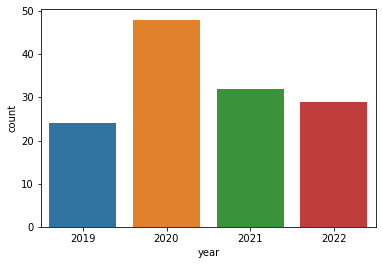

In [30]:
sns.countplot(data=df[cond], x="year")

(130.0, 159.32500000000002)

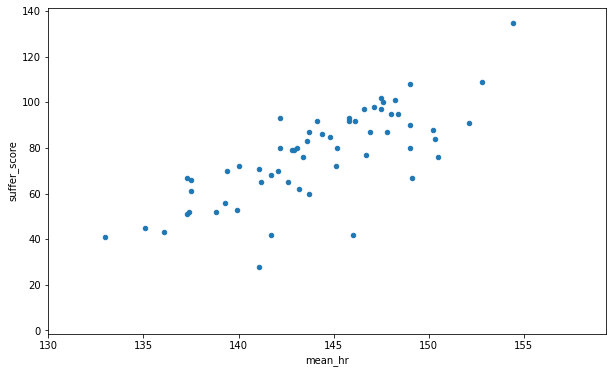

In [39]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
df[cond].plot.scatter(x="mean_hr", y="suffer_score", ax=ax)
#ax.set_ylim(130, None)
ax.set_xlim(130, None)

In [564]:
list(activities)[0].type

'VirtualRide'

data = []
for activity in activities:
    my_dict = activity.to_dict()
    data.append([activity.id]+[my_dict.get(x) for x in my_cols])
    
# Add id to the beginning of the columns, used when selecting a specific activity
my_cols.insert(0,'id')

In [159]:
data_ = client.get_activity_streams(6314126019, types=)

In [160]:
data_.keys()

dict_keys(['distance'])

In [33]:
data_ = client.get_activity_streams(6314126019, types=["time", "heartrate", "watts"])

In [34]:
data_.items()
#data_["distance"].data

dict_items([('watts', <Stream type=watts resolution=high original_size=3578>), ('distance', <Stream type=distance resolution=high original_size=3578>), ('heartrate', <Stream type=heartrate resolution=high original_size=3578>), ('time', <Stream type=time resolution=high original_size=3578>)])

In [35]:
data_

{'watts': <Stream type=watts resolution=high original_size=3578>,
 'distance': <Stream type=distance resolution=high original_size=3578>,
 'heartrate': <Stream type=heartrate resolution=high original_size=3578>,
 'time': <Stream type=time resolution=high original_size=3578>}

In [36]:
empty_dict = {}
for name, stream in data_.items():
    empty_dict[name] = stream.data

In [37]:
df2 = pd.DataFrame(empty_dict)
df2 = df2.astype("float")
print(df2["watts"].isna().sum())
df2 = df2.dropna(subset=["watts"])
df2.head()

1


watts  distance  heartrate  time
1  138.0       2.1      101.0   1.0
2  138.0       4.3      101.0   2.0
3  139.0       6.7      101.0   3.0
4  140.0       9.8      101.0   4.0
5  140.0      13.4      101.0   5.0

<AxesSubplot:xlabel='watts', ylabel='heartrate'>

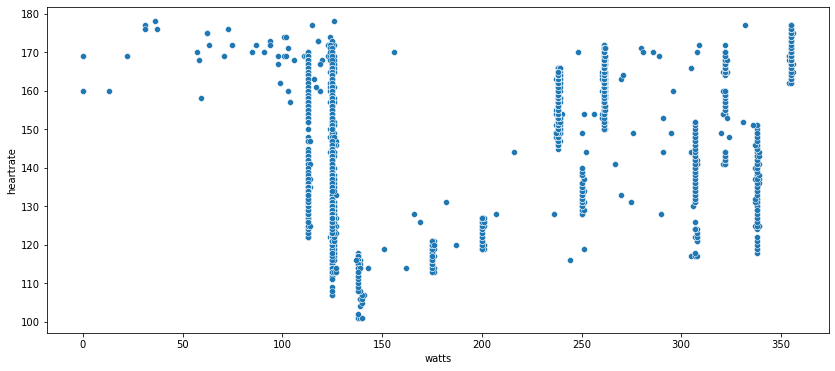

In [50]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(14,6))
sns.scatterplot(data=df2, x="watts", y="heartrate", ax=ax)

In [197]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

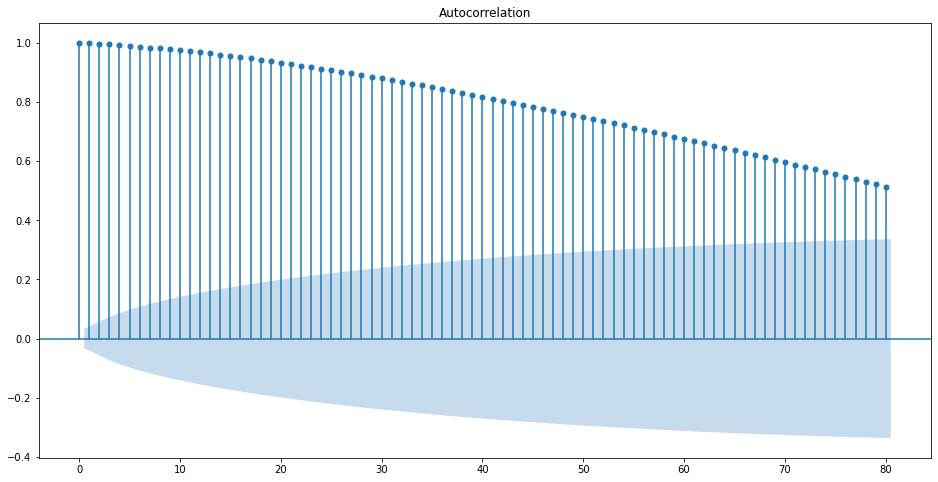

In [194]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
plot_acf(df2["heartrate"], lags=80, ax=ax);

NameError: name 'plot_pacf' is not defined

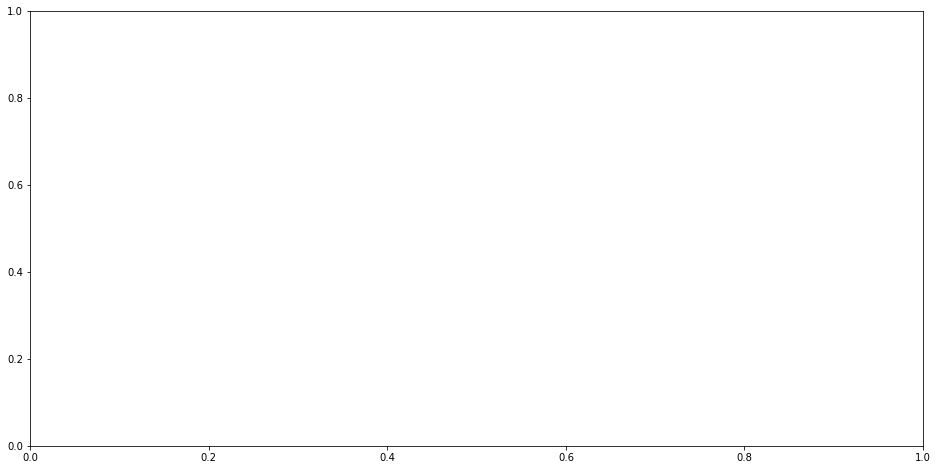

In [38]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
plot_pacf(df2["heartrate"], lags=40, ax=ax);

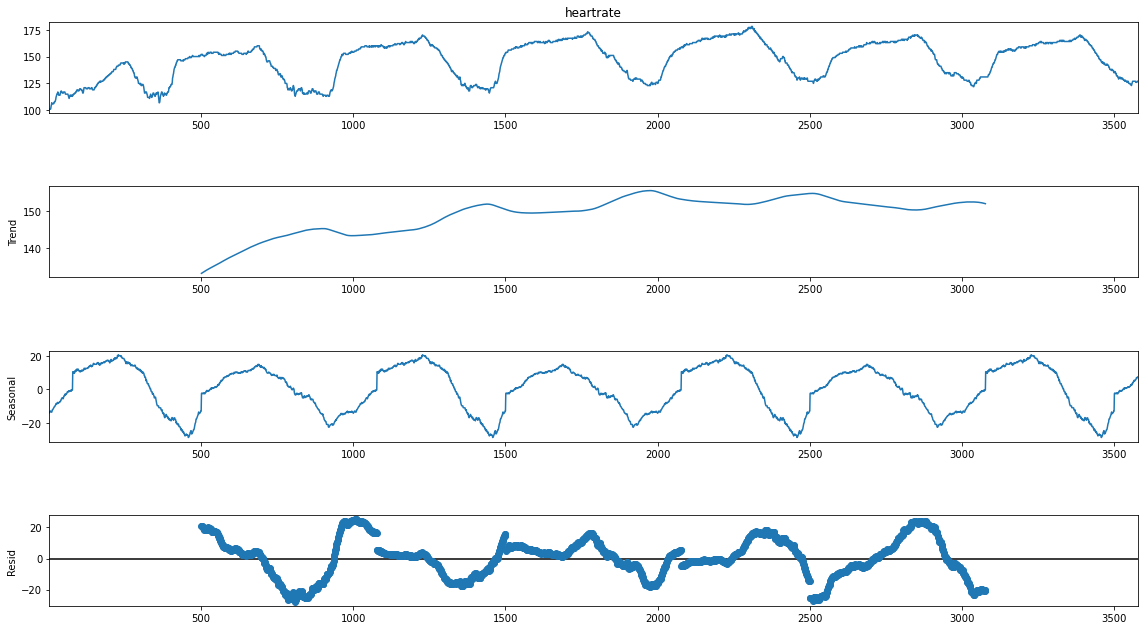

In [228]:
#fig, ax = plt.subplots(1,1, figsize=(16,8))
hej = seasonal_decompose(df["heartrate"], model="add", period=1000).plot()
hej.set_figheight(10)
hej.set_figwidth(18)



<AxesSubplot:>

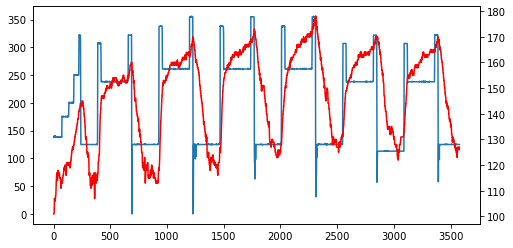

In [52]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df2["watts"].plot(ax=ax)
ax2 = ax.twinx()
df2["heartrate"].plot(ax=ax2, color="red")

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

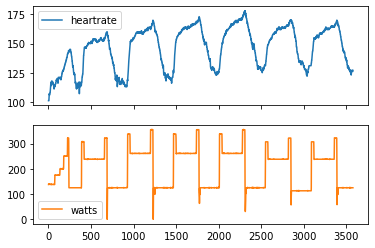

In [53]:
df2[["heartrate", "watts"]].plot(subplots=True)

In [54]:
df2

watts  distance  heartrate    time
1     138.0       2.1      101.0     1.0
2     138.0       4.3      101.0     2.0
3     139.0       6.7      101.0     3.0
4     140.0       9.8      101.0     4.0
5     140.0      13.4      101.0     5.0
...     ...       ...        ...     ...
3573  125.0   30410.5      126.0  3573.0
3574  125.0   30417.3      126.0  3574.0
3575  125.0   30425.2      126.0  3575.0
3576  125.0   30431.7      127.0  3576.0
3577  125.0   30438.4      127.0  3577.0

[3577 rows x 4 columns]

In [55]:
df2["training"] = df2.watts > 150
df2["training_diff"] = df2.training.diff().fillna(0)
df2["training_diff_cumsum"] = df2.training_diff.cumsum()
df2["time_since_rest"] = df2.groupby("training_diff_cumsum")["training"].transform("cumsum")
df2["joules"] = df2.watts.cumsum()
df2["watts_rolling"] = df2.watts.rolling(100, min_periods=1).mean()#.fillna(method="bfill")

<AxesSubplot:>

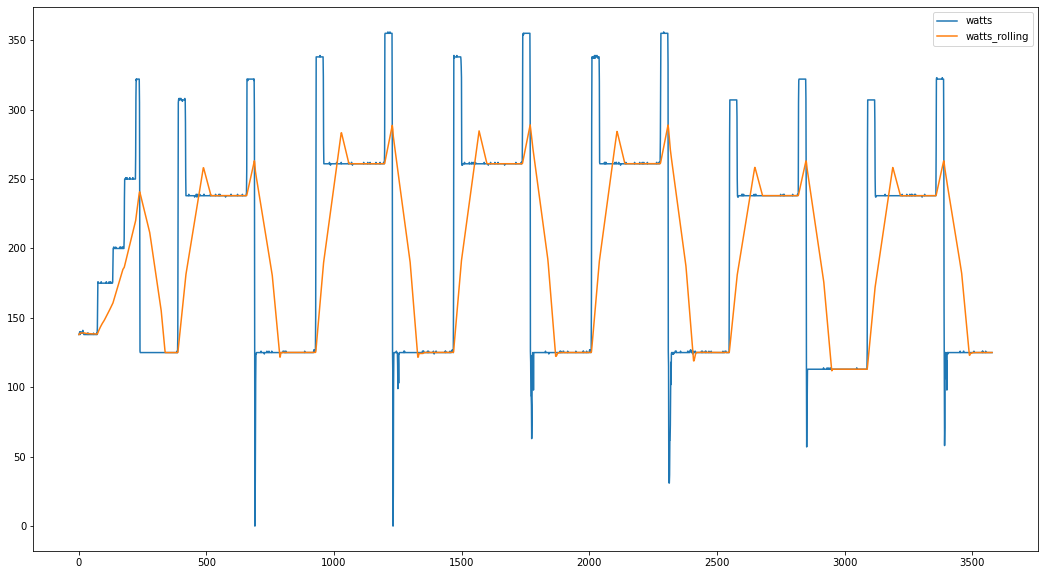

In [56]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
df2[["watts", "watts_rolling"]].plot(subplots=False, ax=ax)

In [57]:
#raw_data = df.drop(columns=["distance", "heartrate"]).copy()
raw_data = df2[["time", "watts", "heartrate", "joules", "watts_rolling"]].copy()

In [58]:
num_train_samples = int(0.6 * len(raw_data))
num_val_samples = int(0.2 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 2146
num_val_samples: 715
num_test_samples: 716


In [439]:
from lightgbm import LGBMRegressor as lgbmr
lgbm = lgbmr()

In [440]:
train_size = int(0.8*len(df))
df_train = df[:train_size]
df_test = df[train_size:]
x_train, y_train = df_train[["watts", "time"]], df_train["heartrate"]
x_test, y_test = df_test[["watts", "time"]], df_test["heartrate"]

In [441]:
lgbm.fit(x_train, y_train)

LGBMRegressor()

In [442]:
preds_test = lgbm.predict(x_test)
preds_train = lgbm.predict(x_train)

In [40]:
import statsmodels.api as sm

In [454]:
#X = sm.add_constant(df[["watts", "time", "time_since_rest"]])
X = sm.add_constant(df[["watts", "time_since_rest"]])
model = sm.OLS(df[:train_size]["heartrate"], X[:train_size])
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              heartrate   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     1159.
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:39:01   Log-Likelihood:                -11554.
No. Observations:                2861   AIC:                         2.311e+04
Df Residuals:                    2858   BIC:                         2.313e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             130.7842      0.860    1

In [456]:
df["linear"] = model.predict(X)

In [457]:
df["train_pred"] = 100
df["test_pred"] = 100
df.loc[df.index <= train_size, "train_pred"] = preds_train
df.loc[df.index > train_size, "test_pred"] = preds_test

<AxesSubplot:>

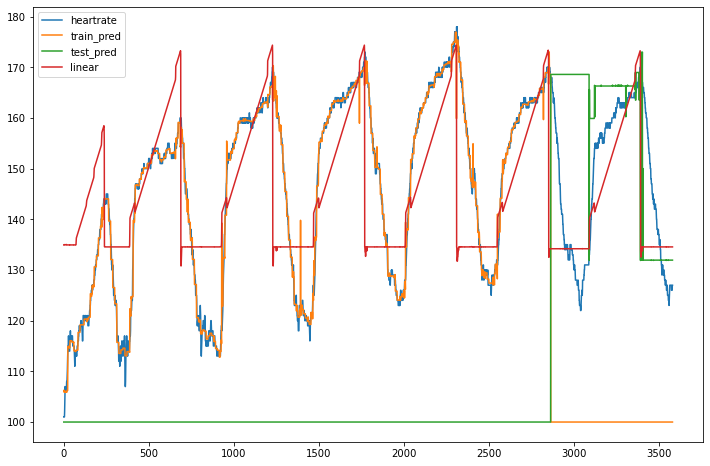

In [458]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
df[["heartrate", "train_pred", "test_pred", "linear"]].plot(ax=ax)

In [61]:
raw_data = raw_data.drop(columns="time").copy()

In [59]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [66]:
temperature = df2["heartrate"]
mean_hr = temperature[:num_train_samples].mean(axis=0)
hr_norm = temperature.copy()
hr_norm -= mean_hr
std_hr = temperature[:num_train_samples].mean(axis=0)
hr_norm /= std_hr

In [ ]:
import numpy as np 
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)
 
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [67]:
temperature = hr_norm
sampling_rate = 1#6 
sequence_length = 100#120 
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 32 
  
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

full_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data,
    targets = None,
    shuffle = False,
    sequence_length = sequence_length,
    batch_size=1
)

In [321]:
for samples in full_dataset:
    print("samples shape:", samples.shape)
    break

samples shape: (1, 100, 1)


In [322]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (32, 100, 1)
targets shape: (32,)


In [232]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. 
    samples_seen = 0 
    for samples, targets in dataset:
        #preds = targets[:, -1, 1] * std[1] + mean[1]
        preds = np.mean(targets)
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
  
print(f"Train MAE: {evaluate_naive_method(train_dataset):.2f}") 
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Train MAE: 0.09
Validation MAE: 0.04


ZeroDivisionError: float division by zero

In [295]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
print(model.summary())
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
#model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                816       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
66/66 [==============================] - 2s 14ms/step - loss: 0.0951 - mae: 0.1624 - val_loss: 0.0490 - val_mae: 0.1469
Epoch 2/10
66/66 [==============================] - 1s 1

In [67]:
raw_data.shape

(3577, 2)

In [150]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 60, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 20, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 4, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [151]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
print(model.summary())
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 120, 2)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 61, 8)             968       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 30, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 11, 8)             1288      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 5, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 2, 8)              264 

In [259]:
raw_data

watts
0          NaN
1    -0.858203
2    -0.858203
3    -0.844914
4    -0.831626
...        ...
3573 -1.030952
3574 -1.030952
3575 -1.030952
3576 -1.030952
3577 -1.030952

[3578 rows x 1 columns]

In [97]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#x = layers.LSTM(16)(inputs)
x = layers.Conv1D(filters=30, kernel_size=7, strides=1, padding="causal", activation="relu")(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16, return_sequences=False)(x)
x = layers.Dense(8, activation="relu")(x)
#x = layers.Dense(1)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    #keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch/20))
]
opt = keras.optimizers.Adam(learning_rate=0.001)
#model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.compile(optimizer=opt, loss="mse", metrics=["mae", "mse"])
print(model.summary())
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 4)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 30)           870       
                                                                 
 lstm_12 (LSTM)              (None, 100, 16)           3008      
                                                                 
 lstm_13 (LSTM)              (None, 16)                2112      
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,135
Trainable params: 6,135
Non-trainable p

In [100]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


(-0.0001, 0.002)

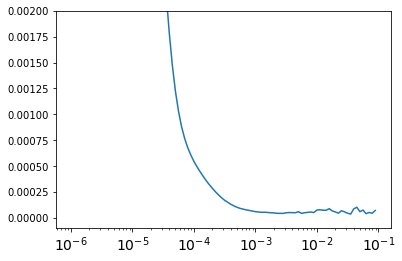

In [92]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xticks(fontsize=14);
plt.ylim(-0.0001, 0.002)
#plt.axis([1e-8, 1e-4, 0, 30])

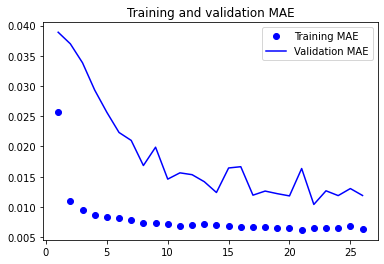

In [98]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

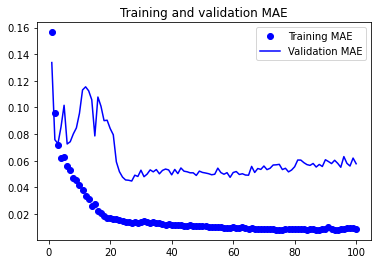

In [210]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [71]:
model.evaluate(val_dataset)

20/20 [==============================] - 0s 8ms/step - loss: 9.0820e-04 - mae: 0.0224 - mse: 9.0820e-04


[0.0009082037140615284, 0.02236301638185978, 0.0009082037140615284]

In [72]:
model.evaluate(test_dataset)

17/17 [==============================] - 0s 9ms/step - loss: 0.0017 - mae: 0.0338 - mse: 0.0017


[0.001651681843213737, 0.03383307158946991, 0.001651681843213737]

In [73]:
test = model.predict(full_dataset)
test

array([[-0.17310119],
       [-0.16898991],
       [-0.16760224],
       ...,
       [-0.2265367 ],
       [-0.22493716],
       [-0.22468272]], dtype=float32)

In [74]:
test.squeeze(1)#.shape

array([-0.17310119, -0.16898991, -0.16760224, ..., -0.2265367 ,
       -0.22493716, -0.22468272], dtype=float32)

In [75]:
test * std_hr + mean_hr

array([[117.97026 ],
       [118.55679 ],
       [118.75477 ],
       ...,
       [110.34683 ],
       [110.575035],
       [110.61133 ]], dtype=float32)

In [78]:
len(df2) - len(test)

99

In [79]:
df2.loc[df2.index > 99, "lstm"] = test.squeeze(1) * std_hr + mean_hr
df2.lstm.fillna(100, inplace=True)
df2.lstm = df2.lstm.astype("float")

In [ ]:
print(int(len(df) - 0.1*len(df)))
print(int(len(df) - 0.2*len(df)))

3219
2861


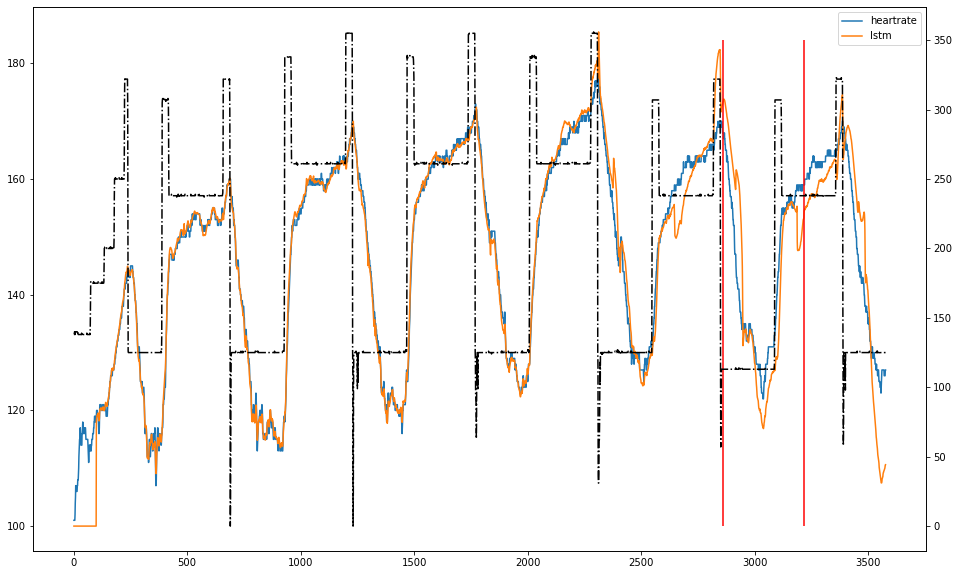

In [81]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
ax2 = ax.twinx()
#df[["heartrate", "train_pred", "test_pred", "linear", "lstm"]].plot(ax=ax)
df2[["heartrate", "lstm"]].plot(ax=ax)
df2["watts"].plot(ax=ax2, label="watts", color="black", linestyle="-.")
ax2.vlines(3219, 0, 350, color="red")
ax2.vlines(2861, 0, 350, color="red")

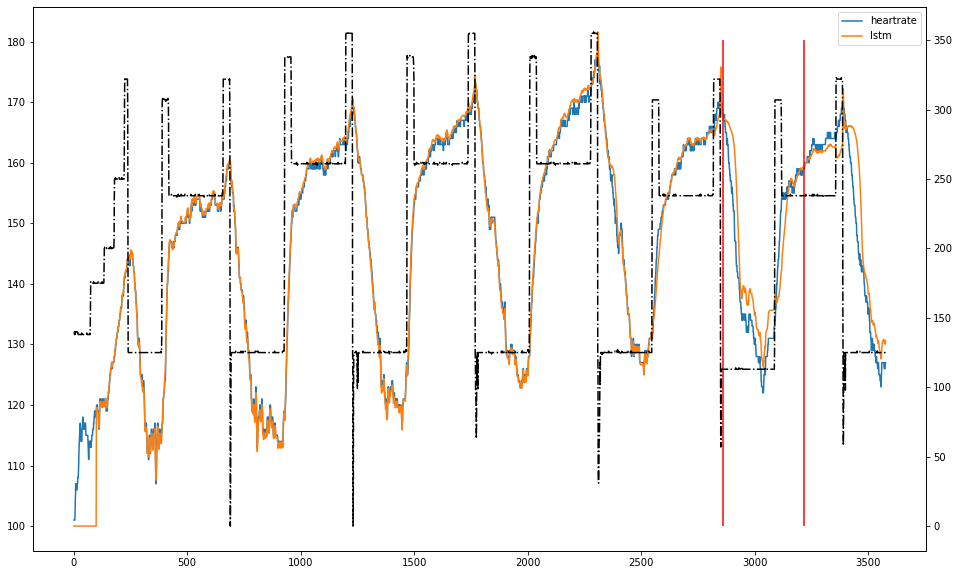

In [539]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
ax2 = ax.twinx()
#df[["heartrate", "train_pred", "test_pred", "linear", "lstm"]].plot(ax=ax)
df[["heartrate", "lstm"]].plot(ax=ax)
df["watts"].plot(ax=ax2, label="watts", color="black", linestyle="-.")
ax2.vlines(3219, 0, 350, color="red")
ax2.vlines(2861, 0, 350, color="red")

<AxesSubplot:>

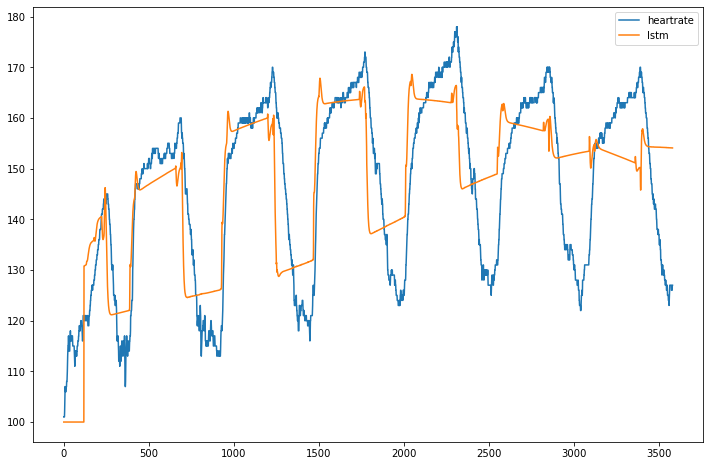

In [140]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
#df[["heartrate", "train_pred", "test_pred", "linear", "lstm"]].plot(ax=ax)
df[["heartrate", "lstm"]].plot(ax=ax)